# Project 3: Part 2
## Web APIs & NLP

###  Background
There has been a surge in demand for data professionals in recent years. This led to an increased competition in the space for coding bootcamps. Competitors like Hack Reactor, Le Wagon, Vertical Institute, and Rocket Academy, have risen to meet the demands. If no action is taken, General Assembly may be faced with decline in market share, poor marketing ROI, and poorer lead generation. 

The General Assembly marketing team would need to better identify the online presence of a bootcamp seeker as opposed to that of the computer science major to aid in tergeted advertising. As both are fairly similar in nature, efforts to further segregate the two targets could yield better advertising ROI.

Keywords are an important aspect of the digital advertising, allowing for targeted strategies at all levels of the marketing funnel. They also guide marketing teams on the sort of advertising content that is required.

Thus, the aim is to segment and target the right audience for amrketing efforts streamline marketing efforts, rasie brand awareness with interested individuals, and increase advertising ROI. 

### Problem Statement
Build a model with at least 90% accuracy that helps to identify between those who are looking for bootcamp style learning as oppose to computer science majors or prospective students based on the words they use online. 

### Data Cleaning, EDA, Modeling
This notebook will focus on the above listed. This is a continuation from Part 1. 

### Data Dictionary
#### Dataset name: df 
##### This contains data that were scraped from Reddit to be used in the project.
|Feature|Type|Description|
|---|---|---|
|subreddit|string| The subreddit the posts are extracted from|
|title|string| Title of the posts|
|selftext|string|Body of the posts|

#### Dataset name: cbc_clean
##### codingbootcamp cleaned and preprocessed data
|Feature|Type|Description|
|---|---|---|
|subreddit|string| Subreddit: codingbootcamp|
|title|string| Title of the posts|
|selftext|string|Body of the posts|
|text|string|title and selftext combined|
|clean_text|string|Text that have been processed and vectorized|

#### Dataset name: cm_clean
##### csMajors cleaned and preprocessed data
|Feature|Type|Description|
|---|---|---|
|subreddit|string| Subreddit: csMajors|
|title|string| Title of the posts|
|selftext|string|Body of the posts|
|text|string|title and selftext combined|
|clean_text|string|Text that have been processed and vectorized|

#### Dataset name: df_clean
##### Dataset used for modelling
|Feature|Type|Description|
|---|---|---|
|subreddit|string| The different subreddits that have been cleaned|
|title|string| Title of the posts|
|selftext|string|Body of the posts|
|text|string|title and selftext combined|
|clean_text|string|Text that have been processed and vectorized|
|baseline|string|Only contain words used for baseline model|

### Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import nltk
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score

As the data is scraped off the web, it needs to be made understandable for the model. A series of cleaning processes will need to take place to enable this. These processes consists of removing punctuations, tokenize the data, remove stopwords and followed by lemmatization of the data. 

In [2]:
# Load data
df = pd.read_csv('data/df.csv')

Through initial scanning of the data it is found that there are posts where the body of the post has been [removed] or [deleted] by the moderators of the subreddit. This indicates that what was contained within it was not suitable to the subreddit. By replacing these words it will help with later on with the accuracy of the model as it would not be swayed by the contant reappareance of [removed] or [deleted]. 

In [3]:
# Remove the words [removed] and [deleted] from selftexts
df['selftext'] = df['selftext'].replace('[removed]', '')
df['selftext'] = df['selftext'].replace('[deleted]', '')

'Title' and 'selftext' are where the model is going to be trained on. Thus, both columns will be combined for a more efficient process.

In [4]:
# Combine 'selftext' and 'title' columns
df['text'] = df['selftext'] + '' + df['title']

In [5]:
# Check Null values
null_stats = pd.DataFrame(df.isnull().sum(), columns = ['missing_value_count'])
null_stats.loc[:,'% of dataset'] = np.round(null_stats.loc[:,'missing_value_count']/df.shape[0]*100,2)
null_stats.loc[null_stats.loc[:,'missing_value_count']>0,:].sort_values(by='missing_value_count',ascending=False)

,missing_value_count,% of dataset
selftext,895,13.8
text,895,13.8


In [6]:
# Remove rows with null values
df.dropna(subset =['text'],inplace=True)

The null values are consistent with the difference in the number of rows between the inital 2 dataframes. As it is just 5 rows out of the over 3000 rows, removing them would not incur much of a difference to the training of the model. 

Now that the data is removed of null values it is ready for further processing. This includes tokenizing and lemmatization. 

In [7]:
# Instantiate Lemmatizer
wn = nltk.WordNetLemmatizer()

# Instantiate stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [8]:
# Create function to automate the process
def clean_text(text):
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = ' '.join([wn.lemmatize(word) for word in tokens if word not in stopwords])
    return text

In [9]:
# Apply function to df
df['clean_text'] = df['text'].apply(clean_text)

In [10]:
df.head()

,subreddit,selftext,title,text,clean_text
0,codingbootcamp,Helloo!! I‘m looking for bootcamps and the bes...,IronHack vs Le Wagon,Helloo!! I‘m looking for bootcamps and the bes...,helloo looking bootcamps best two option found...
1,codingbootcamp,So I’ve been accepted into a local college tha...,Is an associates degree enough?,So I’ve been accepted into a local college tha...,accepted local college offer college name dipl...
2,codingbootcamp,I mean while it does sound too good to be true...,Is freecodingbootcamp.org legit?,I mean while it does sound too good to be true...,mean sound good true im sure anyone would go p...
3,codingbootcamp,"Hey guys, so I been holding onto the idea of b...","Artist to Coder, What are my options?","Hey guys, so I been holding onto the idea of b...",hey guy holding onto idea becoming immersed wo...
5,codingbootcamp,"Hey everyone, is there any survey on entry lev...",Entry Level Developer Salary,"Hey everyone, is there any survey on entry lev...",hey everyone survey entry level bootcamp gradu...


The clean_text is now ready for EDA and model training. 

### EDA

As the problem statement dictates, it is important identify keywords that highlight the individual subreddits. 

Begin by splitting the dataframe into the individual subreddits.

In [11]:
# Split df to the 2 subreddits; codingbootcamp, csmajors

cbc_clean = df[df['subreddit'] == 'codingbootcamp']
cm_clean = df[df['subreddit'] == 'csMajors']

To identify the most used words, the dataframes need to go through a series of processes. It involves vectorizing the dataframe, then into a sparse matrix, before it the individual words can be summed up for evaluation.

In [12]:
# Create a function to vectorize and create sparse matrix for df and return the word count

def sparse_ngram(df, num, top):
    #create ngram
    vectorizer = CountVectorizer(ngram_range=(num,num))
    #fit transform
    matrix = vectorizer.fit_transform(df)
    # Create sparse matrix and store as df
    df_matrix = pd.DataFrame(data = matrix.toarray(), 
                             columns = vectorizer.get_feature_names_out())
    
    count = df_matrix.sum(axis=0)
    print(count.sort_values(ascending=False).head(top))
    
    return count

In [13]:
# Use function to create unigram sparse df of both cbc_clean

cbc_uni = sparse_ngram(cbc_clean['clean_text'],1, 50)

bootcamp      2207
coding        1544
job           1427
would         1238
get           1149
im            1117
like          1095
time          1083
know           900
experience     824
program        823
camp           788
course         774
want           756
anyone         738
one            720
boot           710
work           697
looking        658
bootcamps      633
year           629
good           618
learn          610
also           574
people         571
really         566
week           554
help           553
career         542
month          491
ive            483
need           482
learning       463
start          462
make           458
code           453
dont           450
question       437
degree         432
go             431
tech           428
full           418
going          398
software       397
project        396
lot            395
academy        381
much           376
take           374
feel           368
dtype: int64


From these top 50 words, 'bootcamp' and 'bootcamps' are identified. As it is in the name of the subreddit, it would not be a good indicator of keywords that highlight the subreddit, so it will be removed. The word coding was left in as its a term used for describing the different coding languages, techniques, preference in the industry. In this list there are also other stopwords to be removed such as 'im', 'also', 'really' ive', etc. that on its own does not really make much sense. By removing these stopwords, it would give a better indicator of words that key to this subreddit. 

In [14]:
# List to stopwords to remove
cbc_stopwords = ['bootcamp', 'would', 'get', 'im', 'like', 'know','anyone','boot', 'good', 'question', 'people', 'help', 'camp', 'want', 'one', 'looking', 'bootcamps', 'also', 'really', 'need', 'ive', 'make', 'dont', 'go', 'going', 'lot', 'take', 'much']


In [15]:
# Create function to remove stopwords
def remove_stopwords(df, stopwords):
    df = df .split(' ')
    text = ' '.join([word for word in df if word not in stopwords])
    return text

In [16]:
# Remove stopwords from cbc_clean
cbc_clean['clean_text'] = cbc_clean['clean_text'].apply(lambda x: remove_stopwords(x, cbc_stopwords))

In [17]:
# Recrreate matrix
cbc_uni = sparse_ngram(cbc_clean['clean_text'],1,20)

coding        1544
job           1427
time          1083
experience     824
program        823
course         774
work           697
year           629
learn          610
week           554
career         542
month          491
learning       463
start          462
code           453
degree         432
tech           428
full           418
software       397
project        396
dtype: int64


From here the top 20 words now give a hint of what the subreddit contains. This also expresses the concerns and importance that the individuals have. 

In [18]:
# Save top 20 words into df
top_cbc_uni = cbc_uni.sort_values(ascending=False).head(20 )

top_cbc_uni

coding        1544
job           1427
time          1083
experience     824
program        823
course         774
work           697
year           629
learn          610
week           554
career         542
month          491
learning       463
start          462
code           453
degree         432
tech           428
full           418
software       397
project        396
dtype: int64

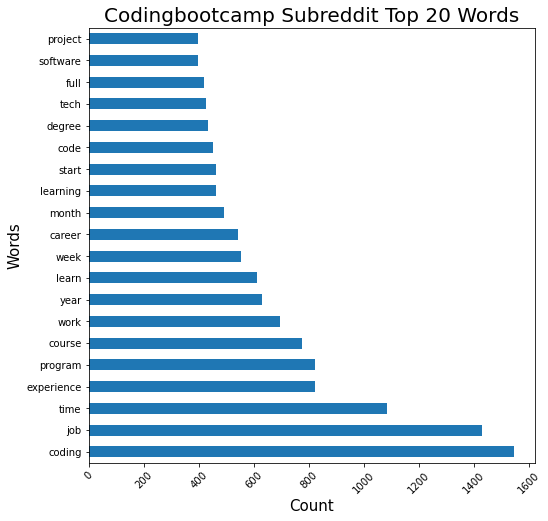

In [19]:
# plot top 20 words into a bar chart
cbc_bar = top_cbc_uni.plot(kind = 'barh', figsize = (8,8))

cbc_bar.set_title('Codingbootcamp Subreddit Top 20 Words', fontsize=20)
cbc_bar.set_ylabel('Words', fontsize=15)
cbc_bar.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=45);

plt.savefig('visuals/cbc_uni20.png')

By creating the bar plot, it gives a clearer picture of what these top 20 words are. 

Now to do the same to r/csMajors. 

In [20]:
cm_uni = sparse_ngram(cm_clean['clean_text'],1, 50)

interview     1435
internship    1368
offer         1152
company        832
would          831
anyone         812
im             808
get            758
like           736
intern         720
know           650
got            635
question       614
one            590
swe            582
time           578
year           547
summer         492
also           434
job            427
round          425
experience     407
work           406
new            406
week           405
really         404
view           398
back           390
want           383
grad           375
final          369
good           368
next           356
take           336
oa             331
people         321
dont           314
first          313
recruiter      307
project        307
think          299
still          292
tech           292
resume         291
school         284
even           283
getting        278
much           278
feel           275
class          275
dtype: int64


In [21]:
# List to stopwords to remove
cm_stopwords = ['would', 'anyone', 'im', 'get', 'like', 'view', 'round', 'one', 'know', 'got', 'question', 'also', 'really', 'back', 'want', 'good', 'people', 'dont', 'think', 'first', 'still', 'even', 'much', 'getting']

In [22]:
# Remove stopwords from cbc_clean

cm_clean['clean_text'] = cm_clean['clean_text'].apply(lambda x: remove_stopwords(x, cm_stopwords))

In [23]:
# Recrreate matrix
cm_uni = sparse_ngram(cm_clean['clean_text'],1,30)

interview     1435
internship    1368
offer         1152
company        832
intern         720
swe            582
time           578
year           547
summer         492
job            427
experience     407
new            406
work           406
week           405
grad           375
final          369
next           356
take           336
oa             331
project        307
recruiter      307
tech           292
resume         291
school         284
class          275
feel           275
heard          271
technical      265
2023           263
day            259
dtype: int64


In [24]:
# Save top 20 words into df
top_cm_uni = cm_uni.sort_values(ascending=False).head(20 )

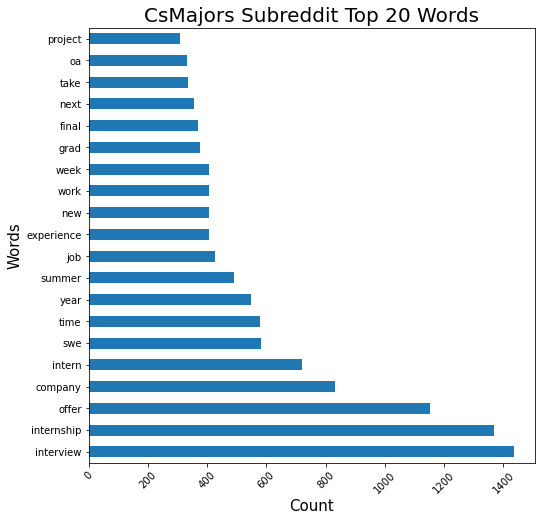

In [25]:
# plot top 20 words into a bar chart
cm_bar = top_cm_uni.plot(kind = 'barh', figsize = (8,8))

cm_bar.set_title('CsMajors Subreddit Top 20 Words', fontsize=20)
cm_bar.set_ylabel('Words', fontsize=15)
cm_bar.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=45);

plt.savefig('visuals/cm_uni20.png')

As singular words do not offer a clear big picture of each subreddit, creating 2-word and 3-word lists would aid in paint this picture. 

In [26]:
# codingbootcamp top 2-word
top_cbc_bi = sparse_ngram(cbc_clean['clean_text'],2,20).sort_values(ascending=False).head(20 )

hack reactor            242
full time               183
app academy             174
part time               172
full stack              167
software engineering    144
general assembly        115
web development         101
html cs                  87
software engineer        84
technical interview      83
computer science         78
tech elevator            75
find job                 73
career change            67
year old                 58
data science             57
software development     56
web dev                  56
coding experience        56
dtype: int64


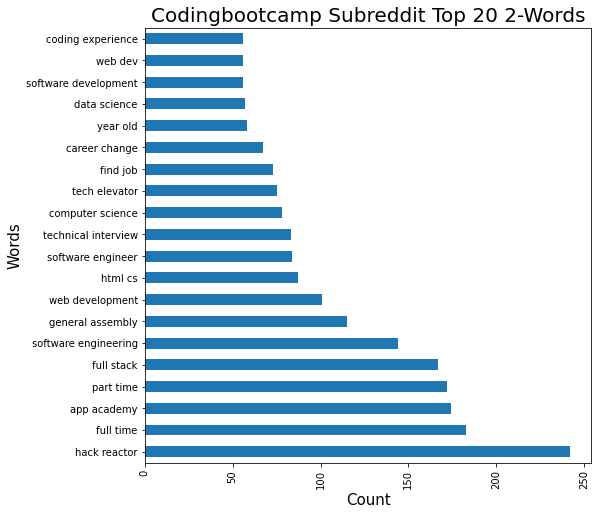

In [27]:
# plot top 20 words into a bar chart
cbcbi_bar = top_cbc_bi.plot(kind = 'barh', figsize = (8,8))

cbcbi_bar.set_title('Codingbootcamp Subreddit Top 20 2-Words', fontsize=20)
cbcbi_bar.set_ylabel('Words', fontsize=15)
cbcbi_bar.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=90);

plt.savefig('visuals/cbc_bi20.png')

In [28]:
# csmajors top 2-word
top_cm_bi = sparse_ngram(cm_clean['clean_text'],2,20).sort_values(ascending=False).head(20 )

new grad                289
swe intern              175
return offer            153
swe internship          137
final interview         126
computer science        107
summer 2023              97
full time                85
technical interview      78
summer internship        73
next year                72
software engineer        70
software engineering     68
interview process        62
tech company             61
big tech                 61
internship offer         59
long take                55
google step              53
phone screen             52
dtype: int64


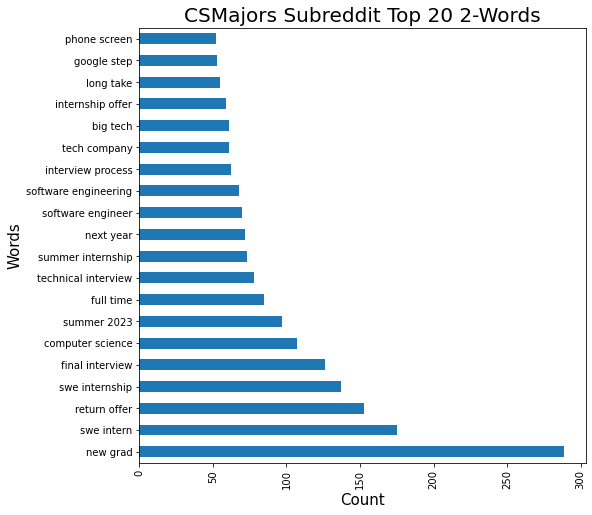

In [29]:
# plot top 20 words into a bar chart
cmbi_bar = top_cm_bi.plot(kind = 'barh', figsize = (8,8))

cmbi_bar.set_title('CSMajors Subreddit Top 20 2-Words', fontsize=20)
cmbi_bar.set_ylabel('Words', fontsize=15)
cmbi_bar.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=90);

plt.savefig('visuals/cm_bi20.png')

The similarities between r/codingbootcamp and r/csMajors are that there are mentions of words revolving around career. The difference is that r/codingbootcamp has stronger emphasis on the schools that offer the bootcamps. This indicates that the schools are very important in the choice for bootcamps. In r/csMajors, the emphasis are on internship placements, particularly a summer internship.

In [30]:
# coding bootcamp top 3-word
top_cbc_tri = sparse_ngram(cbc_clean['clean_text'],3,20).sort_values(ascending=False).head(20)

work full time                  26
data structure algorithm        25
full time job                   25
working full time               24
full stack web                  22
html cs javascript              21
reactor 19 week                 19
part time program               17
hack reactor 19                 16
long story short                16
time part time                  16
able find job                   16
full stack development          15
software engineering program    14
computer science degree         14
algorithm data structure        14
full stack academy              13
feel free comment               13
19 week program                 13
entry level job                 13
dtype: int64


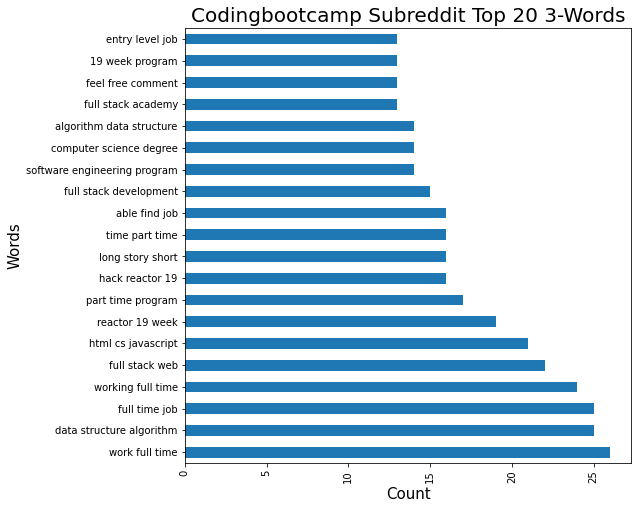

In [31]:
# plot top 20 words into a bar chart
cbctri_bar = top_cbc_tri.plot(kind = 'barh', figsize = (8,8))

cbctri_bar.set_title('Codingbootcamp Subreddit Top 20 3-Words', fontsize=20)
cbctri_bar.set_ylabel('Words', fontsize=15)
cbctri_bar.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=90);

plt.savefig('visuals/cbc_tri20.png')

In [32]:
# csmajors top 3-word
top_cm_tri = sparse_ngram(cm_clean['clean_text'],3,20).sort_values(ascending=False).head(20)

return offer rate                  25
new grad role                      24
summer 2023 internship             22
new grad offer                     20
swe intern interview               19
long take hear                     18
internship summer 2023             18
software engineer intern           17
intern summer 2023                 17
work life balance                  16
data structure algorithm           16
new grad swe                       15
big tech company                   15
swe intern position                14
new grad interview                 13
internship next summer             13
new grad position                  13
software engineering internship    12
havent heard anything              11
software engineering intern        10
dtype: int64


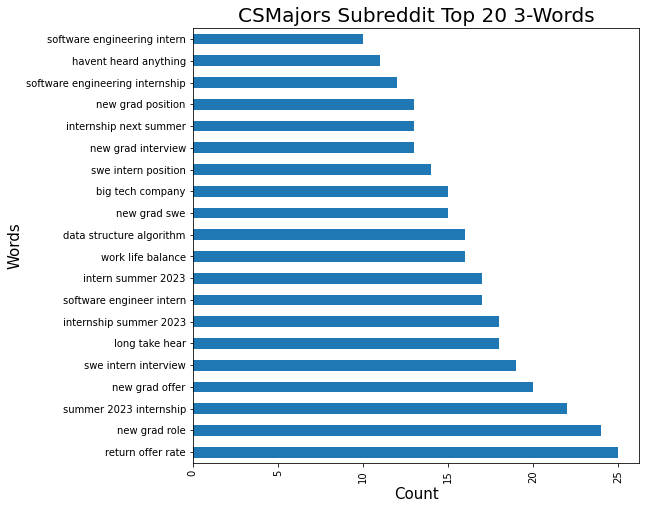

In [33]:
# plot top 20 words into a bar chart
cmtri_bar = top_cm_tri.plot(kind = 'barh', figsize = (8,8))

cmtri_bar.set_title('CSMajors Subreddit Top 20 3-Words', fontsize=20)
cmtri_bar.set_ylabel('Words', fontsize=15)
cmtri_bar.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=90);

plt.savefig('visuals/cm_tri20.png')

From the 3-word breakdown, the line between the 2 subreddits are getting clearer. r/codingbootcamp has bigger emphasis on attaining a job. In general such career bootcamps are targetted to career switchers, this is also in the top 2-word (career switch). It makes sense that attaining a job is of great importance. In r/csMajors, there is strong emphasis in attaining an internship, particularly in summer. This is consistent with the equal emphasis in discussions about interviews.  

In [34]:
# Save both df as csv
cbc_clean.to_csv('data/cbc_clean.csv', index=False)
cm_clean.to_csv('data/cm_clean.csv', index=False)

## Modelling

With the EDA completed, and the data further reduced, it is time to create a model that can help classify between the 2 subreddits. 

Begin with combining the 2 dataframes. 

In [35]:
# Combine both dfs
df_clean = pd.concat([cbc_clean, cm_clean], ignore_index=True)

In [36]:
# Save df as csv
df_clean.to_csv('data/df_clean.csv', index=False)

In [37]:
# Define X and y
X = df_clean['clean_text']
y = df_clean['subreddit']

By using pipelines it would help automate and streamline the modelling process. Fed into the pipelines are the vectorizers and the classifiers to help train our models. By creating different vectorizer and classifier combinations, this allows for a choice of the best model combination. 

Vectorizers:
- CountVectorizer
- N-grams
- TF-IDF

Classifiers:
- Bernoulli Naive Bayes
- Multinomial Naive Bayes

In [38]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

In [39]:
# pipe
# Instantiate a CountVectorizer + BernoulliNB
pipe = Pipeline([('count', CountVectorizer(analyzer = 'word')),
                ('Bern', BernoulliNB(binarize=True))])

# Fit
pipe.fit(X_train, y_train);

# Evalute best model
print('Model Score: ', pipe.score(X_test, y_test))

Model Score:  0.6887298747763864


In [40]:
# pipe2
# Instantiate a CountVectorizer + MultinomialNB
pipe2 = Pipeline([('count', CountVectorizer(analyzer = 'word')),
                ('Multi', MultinomialNB())])

# Fit 
pipe2.fit(X_train, y_train);


# Evalute best model
print('Model Score: ', pipe2.score(X_test, y_test))

Model Score:  0.9364937388193202


In [41]:
# pipe3
# Instantiate a N-Gram + BernoulliNB
pipe3 = Pipeline([('ngram', CountVectorizer(ngram_range=(1,3))),
                ('Bern', BernoulliNB(binarize=True))])

# Fit 
pipe3.fit(X_train, y_train);

# Evalute best model
print('Model Score: ', pipe3.score(X_test, y_test))

Model Score:  0.5330948121645797


In [42]:
# pipe4
# Instantiate a N-Gram + MultinomialNB
pipe4 = Pipeline([('ngram', CountVectorizer(ngram_range=(1,3))),
                ('Multi', MultinomialNB())])

# Fit the gridsearch object to data
pipe4.fit(X_train, y_train);

# Evalute best model
print('Model Score: ', pipe4.score(X_test, y_test))

Model Score:  0.9400715563506261


In [43]:
# pipe5
# Instantiate a TF-IDF + BernoulliNB
pipe5 = Pipeline([('tfidf', TfidfVectorizer(analyzer='word')),
                ('Bern', BernoulliNB(binarize=True))])

# Fit 
pipe5.fit(X_train, y_train);

# Evalute best model
print('Model Score: ', pipe5.score(X_test, y_test))

Model Score:  0.5277280858676208


In [44]:
# pipe6
# Instantiate a TF-IDF + MultinomialNB
pipe6 = Pipeline([('tfidf', TfidfVectorizer(analyzer='word')),
                ('Multi', MultinomialNB())])

# Fit 
pipe6.fit(X_train, y_train);

# Evalute best model
print('Model Score: ', pipe6.score(X_test, y_test))

Model Score:  0.9347048300536672


Pipe4 achieved the best score of 0.940, followed closely by pipe2 and pipe6. Now to optimize pipe4 to find the best parameters so that a greater accuracy can be achieved.

In [45]:
# See parameters for pipe4

pipe4.get_params()

{'memory': None,
 'steps': [('ngram', CountVectorizer(ngram_range=(1, 3))),
  ('Multi', MultinomialNB())],
 'verbose': False,
 'ngram': CountVectorizer(ngram_range=(1, 3)),
 'Multi': MultinomialNB(),
 'ngram__analyzer': 'word',
 'ngram__binary': False,
 'ngram__decode_error': 'strict',
 'ngram__dtype': numpy.int64,
 'ngram__encoding': 'utf-8',
 'ngram__input': 'content',
 'ngram__lowercase': True,
 'ngram__max_df': 1.0,
 'ngram__max_features': None,
 'ngram__min_df': 1,
 'ngram__ngram_range': (1, 3),
 'ngram__preprocessor': None,
 'ngram__stop_words': None,
 'ngram__strip_accents': None,
 'ngram__token_pattern': '(?u)\\b\\w\\w+\\b',
 'ngram__tokenizer': None,
 'ngram__vocabulary': None,
 'Multi__alpha': 1.0,
 'Multi__class_prior': None,
 'Multi__fit_prior': True}

In [46]:
# pipe4
# Instantiate a N-Gram + MultinomialNB
pipe4 = Pipeline([('ngram', CountVectorizer()),
                ('Multi', MultinomialNB())])

# Define dictionary hyperparameters
pipe_params = {'ngram__ngram_range': [(1,1), (2,2), (3,3), (2,3), (1,3)],
               'ngram__max_features': [5000, 7500, 10000],
               'Multi__alpha' : [0, 0.2, 0.5, 0.75, 1]} 

# Instantiate GridSearchCV
pipe_grid = GridSearchCV(pipe4,pipe_params, cv=5, verbose=1)

# Fit the gridsearch object to data
pipe_grid.fit(X_train, y_train);

# Score
print('Best Score: ', pipe_grid.best_score_)

# Best estimator
print('Best Estimator: ', pipe_grid.best_estimator_)

# Evalute best model
print('Model Score: ', pipe_grid.score(X_test, y_test))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best Score:  0.9411773086873383
Best Estimator:  Pipeline(steps=[('ngram',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('Multi', MultinomialNB(alpha=0))])
Model Score:  0.9499105545617174


In [47]:
pred = pipe_grid.predict(X_test)

In [48]:
# Display classfication metrics
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[507  21]
 [ 35 555]]
                precision    recall  f1-score   support

codingbootcamp       0.94      0.96      0.95       528
      csMajors       0.96      0.94      0.95       590

      accuracy                           0.95      1118
     macro avg       0.95      0.95      0.95      1118
  weighted avg       0.95      0.95      0.95      1118



A confusion matrix is a convenient way to visualise a model's performance. From here we can we see that our predictions lined up very well with the actuals across the positive and negative subsets of the data. 

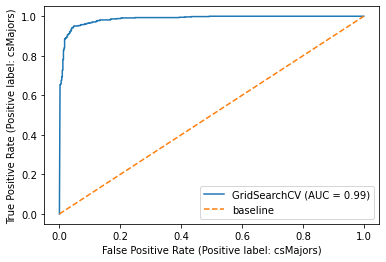

In [49]:
# Plot ROC-AUC curve

plot_roc_curve(pipe_grid, X_test, y_test)
plt.plot([0,1],[0,1], label = 'baseline', linestyle='--')
plt.legend();

In [50]:
roc_auc_score(y_test, pipe_grid.predict_proba(X_test)[:,1])

0.9861485618900874

From this ROC-AUC curve, we can see that the score is at 98.6%, which is as good as it gets. This indicates that out positives and negatives are perfectly separated and out model is good. 

#### Baseline model

A baseline model will be created based on 'obvious' keywords. 
The words are : bootcamp, bootcamps, boot, camp, coding, code. 
These words are chosen as they are what people would normally search for in relation to finding an appropriate bootcamp. 

In [51]:
# List of obvious words
baseline_words = ['bootcamp', 'bootcamps', 'boot', 'camp', 'code', 'coding']

In [52]:
# Create function to preprocess dataframe to only include the obvious words
def baseline(text):
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = ' '.join([wn.lemmatize(word) for word in tokens if word in baseline_words])
    return text

In [53]:
# Apply function to df
df_clean['baseline'] = df_clean['text'].apply(baseline)

In [54]:
df_clean.head()

,subreddit,selftext,title,text,clean_text,baseline
0,codingbootcamp,Helloo!! I‘m looking for bootcamps and the bes...,IronHack vs Le Wagon,Helloo!! I‘m looking for bootcamps and the bes...,helloo best two option found presence south am...,bootcamps
1,codingbootcamp,So I’ve been accepted into a local college tha...,Is an associates degree enough?,So I’ve been accepted into a local college tha...,accepted local college offer college name dipl...,
2,codingbootcamp,I mean while it does sound too good to be true...,Is freecodingbootcamp.org legit?,I mean while it does sound too good to be true...,mean sound true sure performing scam without r...,boot
3,codingbootcamp,"Hey guys, so I been holding onto the idea of b...","Artist to Coder, What are my options?","Hey guys, so I been holding onto the idea of b...",hey guy holding onto idea becoming immersed wo...,coding coding coding bootcamp coding bootcamps...
4,codingbootcamp,"Hey everyone, is there any survey on entry lev...",Entry Level Developer Salary,"Hey everyone, is there any survey on entry lev...",hey everyone survey entry level graduate salar...,bootcamp


In [55]:
# Define X and y for baseline model
bl_X = df_clean['baseline']
bl_y = df_clean['subreddit']

In [56]:
# Train test split for baseline model
# Train test split
X_train, X_test, y_train, y_test = train_test_split(bl_X, bl_y, test_size = .2, random_state = 42)

In [57]:
# Fit model based on best model. #pipe4
# Instantiate a N-Gram + MultinomialNB
baseline_mod = Pipeline([('ngram', CountVectorizer()),
                ('Multi', MultinomialNB())])

# Define dictionary hyperparameters
bl_pipe_params = {'ngram__ngram_range': [(1,1), (2,2), (3,3), (2,3), (1,3)],
               'ngram__max_features': [5000, 7500, 10000],
               'Multi__alpha' : [0, 0.2, 0.5, 0.75, 1]} 

# Instantiate GridSearchCV
bl_pipe_grid = GridSearchCV(baseline_mod,bl_pipe_params, cv=5, verbose=1)

# Fit the gridsearch object to data
bl_pipe_grid.fit(X_train, y_train);

# Score
print('Best Score: ', bl_pipe_grid.best_score_)

# Best estimator
print('Best Estimator: ', bl_pipe_grid.best_estimator_)

# Evalute best model
print('Model Score: ', bl_pipe_grid.score(X_test, y_test))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best Score:  0.8302375863922113
Best Estimator:  Pipeline(steps=[('ngram',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('Multi', MultinomialNB(alpha=0))])
Model Score:  0.8121645796064401


In [58]:
bl_pred = bl_pipe_grid.predict(X_test)

In [59]:
# Display classfication metrics
print(confusion_matrix(y_test, bl_pred))
print(classification_report(y_test, bl_pred))

[[318 210]
 [  0 590]]
                precision    recall  f1-score   support

codingbootcamp       1.00      0.60      0.75       528
      csMajors       0.74      1.00      0.85       590

      accuracy                           0.81      1118
     macro avg       0.87      0.80      0.80      1118
  weighted avg       0.86      0.81      0.80      1118



The baseline model displayed lesser consistency amongst the results as compared to selected best model. The f1 score on the baseline is also lower. This further enhance our best model's performance. 

## Evaluation

#### EDA
From the EDA, the initial findings of the top words displayed a lot of words that needed to be removed. There are also words that are abbreviations or coined words that does not make much sense unless you are well versed in both coding bootcamp and CS majors lingo. But the findings from the EDA have been insightful. 

Coding bootcamp redditors discussions' revolve around the different schools that provide bootcamps and securing a job in the industry. It is promising to find 'General Assembly' in the top 20 2-words, however the competitors are still more talked about. This does indicate that General Assembly have ways to go in increasing its presence. The redditors of the subreddit also have placed emphasis in shorter courses. As 'career change' appears in the top 2-words, this indicates that those who choose bootcamps are career switchers and therefore are looking for shorter duration to ultimately get back on the workforce. 

CS majors redditors discussions' revolve around attaining internships. As computer science degrees average around a 4 year duration, it makes sense to see students looking for summer internships during their break. There are more talks about the interview process, technical interviews, and final interviews. As it is assumed that those in the degree course are young and have not entered the workforce, it is reasonable to see that their concerns would be how to get through the interview process. 

#### Modeling
With the data having more stopwords removed after the EDA process, the model has shown great accuracy with a f1 score of 95%. This compared to our baseline model's score of 80% shows that our model definitely has higher accuracy. With this, the model would be able to resonably predict between bootcamp seekers and those looking for a 4-year course. By being able to identify between the 2, General Assembly marketing team can look closer across multiple social platforms and focus their marketing efforts in that direction. 

## Conclusion and Recommendations

#### Moving forward
With more time and resources, more data could be gathered not just from reddit, but across various online platforms. This could help the model identify across mediums as well. Like videos, images, and short texts.

Along with that, a better understanding of the different acronyms and abbreviations within the text post would allow for a more thorough analysis and breakdown. 

Doing a sentiment analsis would also give a better picture of the difference between coding bootcamps and computer science majors. This allows for a different perspective of the students invovled in both educational choices. 

#### Recommendations
Using the model to look at keywords.
The features produced by the model will allow General Assembly marketing team to better identify suitable posts to engage with. 

Automating the model.
Deployment of the model to automatically scan the social media interations across platforms. This helps the team to collate just the posts they need to engage with and evaluate. 

Marketing efforts.
Boost marketing across channels to increase visibility and presence against competitors. By making use of the keywords marketing materials could hone in on those interested in the bootcamp type courses and maybe sway those looking at full degree programs to hop over. 

#### Conclusion
General Assembly needs to stand out from our competitors and be able to accurately and effectively identify potential students. There is a need to increase visibility and be quick in response. In today's fast paced environment, speed is also essential in being able to act before our competitors.

The model is able to correctly identify around 95% of the users who are interested in coding bootcamps. This would allow General Assembly to better maximise the marketing outreach and increase our conversation rate. 